<a href="https://colab.research.google.com/github/MarfredBarrera/State-Selection-Algorithm/blob/main/Safety_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety Filtering
```Author: Kensuke Nakamura```

```Acknowledgements: MPPI planner and Intent Lab floorplans from Leonardo Santos```



In this, we will computationally synthesize and deploy a *safety filter*. We will use Hamilton-Jacobi (HJ) reachability as our safety filter synthesis tool. This will involve computing a backward reachable tube (BRT) for our dynamical system of choice.


In [1]:
# @title Install and import dependencies
!gdown 1UATUlH4Xer6qq5XN4UoFoVZT0OSLSkeR
!pip install --upgrade pip
!pip install "flax>=0.6.6"
!pip install -U "jax[cuda12]"
!pip install "numpy>=1.22"
!pip install --upgrade hj-reachability

# for directories and paths
import os

# for math operations
import numpy as np
import scipy

# for plotting
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# for accelerated computing
import jax
import jax.numpy as jnp

# Python reachability toolbox
import hj_reachability as hj

Downloading...
From: https://drive.google.com/uc?id=1UATUlH4Xer6qq5XN4UoFoVZT0OSLSkeR
To: /content/lx_2d.pgm
100% 36.7k/36.7k [00:00<00:00, 50.5MB/s]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 45.7 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.4.33
    Uninstalling jax-cuda12-pjrt-0.4.33:
      Successfully uninstalled jax-cuda12-pjrt-0.4.33
  Attempting uninstall: nvidia-cuda-nvcc-c

## Problem 1: Multi-Obstacle Safety Policy

In class, we went over how we can derive a safety filter for a vehicle-like robot modeled as its position and heading $x := (p_x, p_y, \theta)$. We will model the robot's continuous-time dynamics via this ordinary differential equation (ODE) below:

\begin{align}
\dot{p}_x &= v \cos(\theta) \\
\dot{p}_y &= v \sin(\theta) \\
\dot{\theta} &= \omega
\end{align}

This robot model is often called a 3D Dubins' car model. The robot’s linear velocity is fixed $v = 0.5$ m/s and it controls its angular velocity, $u := \omega$ which is bounded, $\omega \in [-1, 1]$. Assume the failure set $\mathit{F}$ represents an obstacle centered at $(0, 1)$ and contains any state within a 0.5 m radius circle in the $p_x$-$p_y$ plane irrespective of the heading angle.

1. Mathematically define a signed distance function $\ell(x)$ which encodes $\mathit{F}$ as the sub-zero
level set.

2. Suppose there was another obstacle identical to the first, centered at (x_c, y_c). How could we design a single signed distance function $\ell(x)$ whose zero-sublevel set describes the failure set $\mathit{F}$ induced by both obstacles?

  HINT: Imagine you have two signed distance functions $\ell_{o1}$, $\ell_{o_2}$. Each signed distance function represents the distance from any point in the space to the corresponding obstacle. How could we compose these functions to get a single $\ell(x)$ representing the distance to the nearest obstacle?

3. True or False: The union of unsafe sets for two failure sets is the same as the unsafe set of the union of two failure sets. Explain.

### Solutions

1.1.1 **TODO: your Markdown solution here.**  
1.1.2 **TODO: your Markdown solution here.**  
1.1.3. **TODO: your Markdown solution here.**  

## Numerically Computing Safety Filters via HJ Reachability Analysis

Now let's compute the backwards reachable tube for the same dynamical system above!

In [ ]:
# @title 3D Dubins Car Dynamics
import jax.numpy as jnp

from hj_reachability import dynamics
from hj_reachability import sets
import torch

speed = 0.5
class Dubins3D(dynamics.ControlAndDisturbanceAffineDynamics):
    def __init__(self,
                 max_turn_rate=1.,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None):
        self.speed = speed
        if control_space is None:
            control_space = sets.Box(jnp.array([-max_turn_rate]), jnp.array([max_turn_rate]))
        if disturbance_space is None:
            disturbance_space = sets.Box(jnp.array([0, 0]), jnp.array([0, 0]))
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        _, _, psi = state
        v = self.speed
        return jnp.array([v * jnp.cos(psi), v * jnp.sin(psi), 0.])

    def control_jacobian(self, state, time):
        x, y, _ = state
        return jnp.array([
            [0],
            [0],
            [1],
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [1., 0.],
            [0., 1.],
            [0., 0.],
        ])


def dubins_dynamics_tensor(current_state: torch.Tensor, action: torch.Tensor, dt: float) \
        -> torch.Tensor:
    """
    current_state: shape(num_samples, dim_x)
    action: shape(num_samples, dim_u)

    Implemented discrete time dynamics with RK-4.

    return:
    next_state: shape(num_samples, dim_x)
    """

    def one_step_dynamics(state, action):
        """Compute the derivatives [dx/dt, dy/dt, dtheta/dt]."""
        x_dot = speed*torch.cos(state[:, 2])
        y_dot = speed*torch.sin(state[:, 2])
        theta_dot = action[:, 0]
        return torch.stack([y_dot, x_dot, theta_dot], dim=1)

    # k1
    k1 = one_step_dynamics(current_state, action)
    # k2
    mid_state_k2 = current_state + 0.5 * dt * k1
    k2 = one_step_dynamics(mid_state_k2, action)
    # k3
    mid_state_k3 = current_state + 0.5 * dt * k2
    k3 = one_step_dynamics(mid_state_k3, action)
    # k4
    end_state_k4 = current_state + dt * k3
    k4 = one_step_dynamics(end_state_k4, action)
    # Combine k1, k2, k3, k4 to compute the next state
    next_state = current_state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    next_state[..., -1] = next_state[..., -1] % (2 * np.pi)
    return next_state


Let's instantiate our dynamical system $\dot{x} = f(x, u)$, the state space computation grid $x \in X$, and the margin function $\ell(x)$.

**1.2 TODO: Implement $\ell(x)$ below.**

100%|##########|  2.8000/2.799999952316284 [00:04<00:00,  1.53s/sim_s]


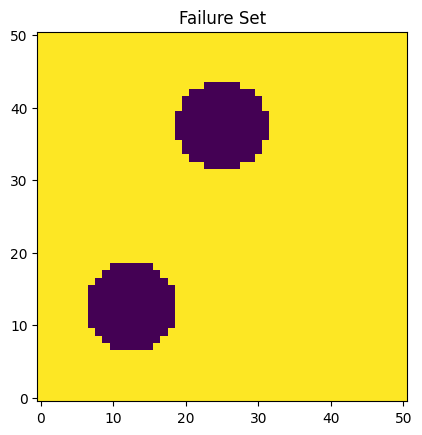

In [ ]:
# Define the dynamical system
dyn_sys = Dubins3D()

# Define the computation grid
grid_min = np.array([-2., -2., 0.]) # in meters
grid_max = np.array([2., 2., 2 * np.pi]) # in meters
num_cells = (51, 51, 51) # in cells
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(grid_min, grid_max),
                                                               num_cells,
                                                               periodic_dims=2)

''' Q1.2 TODO: Implement l(x). '''
# Define the failure set as encoded by a signed distance function.
# We use values to denote this initial signed distance function from
# which the value function is computed.
x_c, y_c, radius = -1.0, -1.0, 0.5
obstacle1 = jnp.linalg.norm(np.array([0.0, 0.0]) - grid.states[..., :2], axis=-1) - radius
obstacle2 = jnp.linalg.norm(np.array([x_c, y_c]) - grid.states[..., :2] , axis=-1) - radius
failure_lx = jnp.minimum(obstacle1, obstacle2)

''' END TODO '''




solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
# Time
time = 0.
target_time = -2.8

# Run the solver
target_values = hj.step(solver_settings, dyn_sys, grid, time, failure_lx, target_time)
plt.title("Failure Set")
plt.imshow(failure_lx[:, :, 0].T>0, origin='lower')
plt.show()


**1.3 Visualize the zero-sublevel set for 2 different values of theta at $(x_c, y_c) = (-1, -1)$ and $(x_c, y_c) = (0, -0.98)$.***

TODO: Your Markdown solution

**1.4 Why do the shape of these BRTs look different??**


TODO: Your Markdown solution


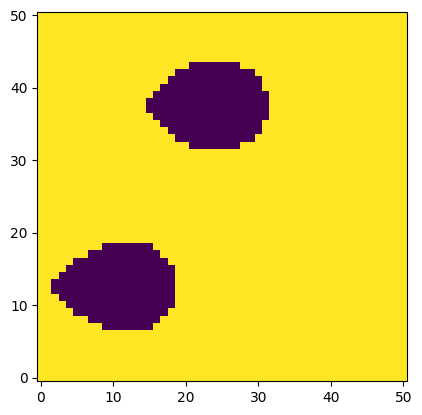

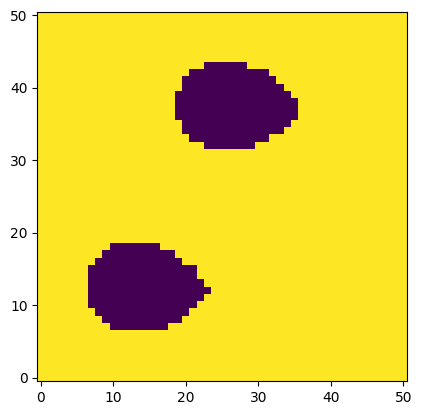

In [ ]:
## 1.3 TODO: Visualization code here
plt.imshow(target_values[:, :, 0].T>0, origin='lower')
plt.show()
plt.imshow(target_values[:, :, 25].T>0, origin='lower')
plt.show()

## END TODO

**1.4 TODO: your Markdown solution here**

## Problem 2: Filtering a nominal policy
We have computed a safety filter for some simple non-convex constraints. Let’s make the problem harder! Now, our constraints will come from the floorplan of the Intent Lab. We provide a floorplan of the Intent Robotics Lab as an occupancy grid to use as our $l(x)$ margin function.

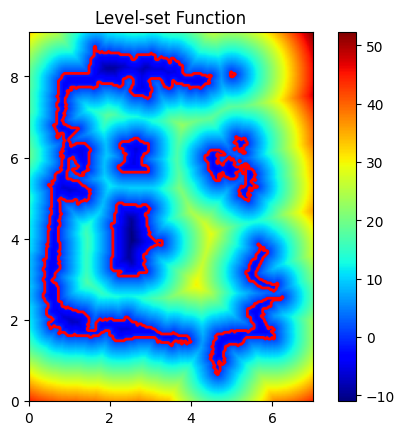

In [ ]:
# @title Generating floorplan l(x) from occupancy grid
from scipy.ndimage import distance_transform_edt, binary_fill_holes
import scipy.ndimage as ndi
from PIL import Image

x_min = 0
x_max = 9.1
y_min = 0
y_max = 7

img = Image.open('lx_2d.pgm')
original_width, original_height = img.size

occupancy_grid = (np.array(img) == 0).astype(int)
occupancy_grid = binary_fill_holes(occupancy_grid)

distance_transform_free = distance_transform_edt(occupancy_grid == 0)
distance_transform_obs = distance_transform_edt(occupancy_grid != 0)
distance_transform = np.where(occupancy_grid == 0, distance_transform_free, -distance_transform_obs)

plt.imshow(distance_transform.T, cmap='jet', origin='lower', extent =[y_min, y_max, x_min, x_max])
plt.colorbar()
plt.contour(distance_transform.T, levels=[0], colors='r', linewidths=2, extent =[y_min, y_max, x_min, x_max])  # Red contour at zero level
plt.title('Level-set Function')
plt.show()

  0%|          |  0.0000/2.799999952316284 [00:00<?, ?sim_s/s]

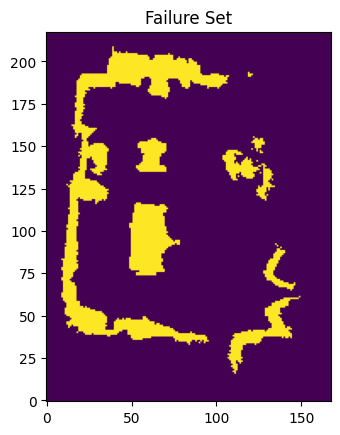

100%|##########|  2.8000/2.799999952316284 [02:20<00:00, 50.02s/sim_s]


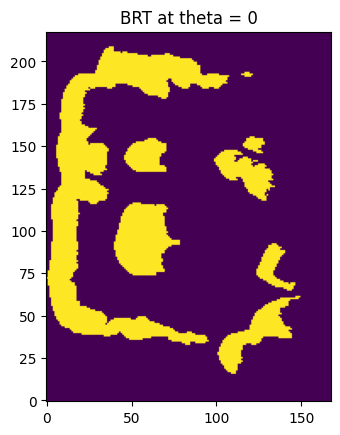

In [ ]:
# @title Solve BRT for floorplan l(x)
# Define the dynamical system
dyn_sys = Dubins3D(control_mode='max')

# Define the computation grid
grid_min = np.array([0., 0., 0.]) # in meters
grid_max = np.array([x_max, y_max, 2 * np.pi]) # in meters
theta_res = 51
num_cells = (distance_transform.shape[0], distance_transform.shape[1], theta_res) # in cells
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(grid_min, grid_max),
                                                               num_cells,
                                                               periodic_dims=2)

values  = np.repeat(distance_transform[:, :, np.newaxis], theta_res, axis=2) # the constraint is only on (p_x, p_y), it is the same for all theta
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
# Time
time = 0.
target_time = -2.8

# Run the solver
target_values = hj.step(solver_settings, dyn_sys, grid, time, values, target_time)

plt.title("Failure Set")
plt.imshow(values[:, :, 0].T<0, origin='lower')
plt.show()

plt.title('BRT at theta = 0')

plt.imshow(target_values[:, :, 0].T<0, origin='lower')
plt.show()

In [ ]:
# @title MPPI Planner
import functools
import logging

import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

logger = logging.getLogger(__name__)


def _ensure_non_zero(cost, beta, factor):
    return torch.exp(-factor * (cost - beta))


def is_tensor_like(x):
    return torch.is_tensor(x) or type(x) is np.ndarray


def squeeze_n(v, n_squeeze):
    for _ in range(n_squeeze):
        v = v.squeeze(0)
    return v

def handle_batch_input(n):
    def _handle_batch_input(func):
        """For func that expect 2D input, handle input that have more than 2 dimensions by flattening them temporarily"""

        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            # assume inputs that are tensor-like have compatible shapes and is represented by the first argument
            batch_dims = []
            for arg in args:
                if is_tensor_like(arg):
                    if len(arg.shape) > n:
                        # last dimension is type dependent; all previous ones are batches
                        batch_dims = arg.shape[:-(n - 1)]
                        break
                    elif len(arg.shape) < n:
                        n_batch_dims_to_add = n - len(arg.shape)
                        batch_ones_to_add = [1] * n_batch_dims_to_add
                        args = [v.view(*batch_ones_to_add, *v.shape) if is_tensor_like(v) else v for v in args]
                        ret = func(*args, **kwargs)
                        if isinstance(ret, tuple):
                            ret = [squeeze_n(v, n_batch_dims_to_add) if is_tensor_like(v) else v for v in ret]
                            return ret
                        else:
                            if is_tensor_like(ret):
                                return squeeze_n(ret, n_batch_dims_to_add)
                            else:
                                return ret
            # no batches; just return normally
            if not batch_dims:
                return func(*args, **kwargs)

            # reduce all batch dimensions down to the first one
            args = [v.view(-1, *v.shape[-(n - 1):]) if (is_tensor_like(v) and len(v.shape) > 2) else v for v in args]
            ret = func(*args, **kwargs)
            # restore original batch dimensions; keep variable dimension (nx)
            if type(ret) is tuple:
                ret = [v if (not is_tensor_like(v) or len(v.shape) == 0) else (
                    v.view(*batch_dims, *v.shape[-(n - 1):]) if len(v.shape) == n else v.view(*batch_dims)) for v in
                       ret]
            else:
                if is_tensor_like(ret):
                    if len(ret.shape) == n:
                        ret = ret.view(*batch_dims, *ret.shape[-(n - 1):])
                    else:
                        ret = ret.view(*batch_dims)
            return ret

        return wrapper

    return _handle_batch_input

class MPPI():
    """
    Model Predictive Path Integral control
    This implementation batch samples the trajectories and so scales well with the number of samples K.

    Implemented according to algorithm 2 in Williams et al., 2017
    'Information Theoretic MPC for Model-Based Reinforcement Learning',
    based off of https://github.com/ferreirafabio/mppi_pendulum
    """

    def __init__(self, dynamics, running_cost, nx, noise_sigma, num_samples=100, horizon=15, device="cpu",
                 dt=0.1,
                 terminal_state_cost=None,
                 lambda_=1.,
                 noise_mu=None,
                 u_min=None,
                 u_max=None,
                 u_init=None,
                 U_init=None,
                 u_scale=1,
                 u_per_command=1,
                 step_dependent_dynamics=False,
                 rollout_samples=1,
                 rollout_var_cost=0,
                 rollout_var_discount=0.95,
                 sample_null_action=False,
                 noise_abs_cost=False):
        """
        :param dynamics: function(state, action) -> next_state (K x nx) taking in batch state (K x nx) and action (K x nu)
        :param running_cost: function(state, action) -> cost (K) taking in batch state and action (same as dynamics)
        :param nx: state dimension
        :param noise_sigma: (nu x nu) control noise covariance (assume v_t ~ N(u_t, noise_sigma))
        :param num_samples: K, number of trajectories to sample
        :param horizon: T, length of each trajectory
        :param device: pytorch device
        :param terminal_state_cost: function(state) -> cost (K x 1) taking in batch state
        :param lambda_: temperature, positive scalar where larger values will allow more exploration
        :param noise_mu: (nu) control noise mean (used to bias control samples); defaults to zero mean
        :param u_min: (nu) minimum values for each dimension of control to pass into dynamics
        :param u_max: (nu) maximum values for each dimension of control to pass into dynamics
        :param u_init: (nu) what to initialize new end of trajectory control to be; defeaults to zero
        :param U_init: (T x nu) initial control sequence; defaults to noise
        :param step_dependent_dynamics: whether the passed in dynamics needs horizon step passed in (as 3rd arg)
        :param rollout_samples: M, number of state trajectories to rollout for each control trajectory
            (should be 1 for deterministic dynamics and more for models that output a distribution)
        :param rollout_var_cost: Cost attached to the variance of costs across trajectory rollouts
        :param rollout_var_discount: Discount of variance cost over control horizon
        :param sample_null_action: Whether to explicitly sample a null action (bad for starting in a local minima)
        :param noise_abs_cost: Whether to use the absolute value of the action noise to avoid bias when all states have the same cost
        """
        self.d = device
        self.dtype = noise_sigma.dtype
        self.K = num_samples  # N_SAMPLES
        self.T = horizon  # TIMESTEPS

        # dimensions of state and control
        self.nx = nx
        self.nu = 1 if len(noise_sigma.shape) == 0 else noise_sigma.shape[0]
        self.lambda_ = lambda_
        self.dt = dt

        if noise_mu is None:
            noise_mu = torch.zeros(self.nu, dtype=self.dtype)

        if u_init is None:
            u_init = torch.zeros_like(noise_mu)

        # handle 1D edge case
        if self.nu == 1:
            noise_mu = noise_mu.view(-1)
            noise_sigma = noise_sigma.view(-1, 1)

        # bounds
        self.u_min = u_min
        self.u_max = u_max
        self.u_scale = u_scale
        self.u_per_command = u_per_command
        # make sure if any of them is specified, both are specified
        if self.u_max is not None and self.u_min is None:
            if not torch.is_tensor(self.u_max):
                self.u_max = torch.tensor(self.u_max)
            self.u_min = -self.u_max
        if self.u_min is not None and self.u_max is None:
            if not torch.is_tensor(self.u_min):
                self.u_min = torch.tensor(self.u_min)
            self.u_max = -self.u_min
        if self.u_min is not None:
            self.u_min = self.u_min.to(device=self.d)
            self.u_max = self.u_max.to(device=self.d)

        self.noise_mu = noise_mu.to(self.d)
        self.noise_sigma = noise_sigma.to(self.d)
        self.noise_sigma_inv = torch.inverse(self.noise_sigma)
        self.noise_dist = MultivariateNormal(self.noise_mu, covariance_matrix=self.noise_sigma)
        # T x nu control sequence
        self.U = U_init
        self.u_init = u_init.to(self.d)

        if self.U is None:
            self.U = self.noise_dist.sample((self.T,))

        self.step_dependency = step_dependent_dynamics
        self.F = dynamics
        self.running_cost = running_cost
        self.terminal_state_cost = terminal_state_cost
        self.sample_null_action = sample_null_action
        self.noise_abs_cost = noise_abs_cost
        self.state = None

        # handling dynamics models that output a distribution (take multiple trajectory samples)
        self.M = rollout_samples
        self.rollout_var_cost = rollout_var_cost
        self.rollout_var_discount = rollout_var_discount

        # sampled results from last command
        self.cost_total = None
        self.cost_total_non_zero = None
        self.omega = None
        self.states = None
        self.actions = None

    @handle_batch_input(n=2)
    def _dynamics(self, state, u, t, dt):
        return self.F(state, u, t, dt) if self.step_dependency else self.F(state, u, dt)

    @handle_batch_input(n=2)
    def _running_cost(self, state, u, t):
        return self.running_cost(state, u, t)

    @handle_batch_input(n=2)
    def _terminal_state_cost(self, state, u):
        return self.terminal_state_cost(state, u)

    def command(self, state):
        """
        :param state: (nx) or (K x nx) current state, or samples of states (for propagating a distribution of states)
        :returns action: (nu) best action
        """
        # shift command 1 time step
        self.U = torch.roll(self.U, -1, dims=0)
        self.U[-1] = self.u_init
        # print(f'state shape as input: {state.shape}')
        return self._command(state)

    def _command(self, state):
        if not torch.is_tensor(state):
            state = torch.tensor(state)
        self.state = state.to(dtype=self.dtype, device=self.d)
        cost_total = self._compute_total_cost_batch()
        # print(f'cost total: {cost_total}')
        beta = torch.min(cost_total)
        self.cost_total_non_zero = _ensure_non_zero(cost_total, beta, 1 / self.lambda_)
        eta = torch.sum(self.cost_total_non_zero)
        self.omega = (1. / eta) * self.cost_total_non_zero
        for t in range(self.T):
            self.U[t] += torch.sum(self.omega.view(-1, 1) * self.noise[:, t], dim=0)
        action = self.U[:self.u_per_command]
        # reduce dimensionality if we only need the first command
        if self.u_per_command == 1:
            action = action[0]
        return action

    def reset(self):
        """
        Clear controller state after finishing a trial
        """
        self.U = self.noise_dist.sample((self.T,))

    def _compute_rollout_costs(self, perturbed_actions):
        K, T, nu = perturbed_actions.shape
        assert nu == self.nu

        cost_total = torch.zeros(K, device=self.d, dtype=self.dtype)
        cost_samples = cost_total.repeat(self.M, 1)
        cost_var = torch.zeros_like(cost_total)

        # allow propagation of a sample of states (ex. to carry a distribution), or to start with a single state
        # self.state.shape = [1, dim_x]
        # make state.shape = K, self.nx
        if self.state.shape == (K, self.nx):
            state = self.state
        else:
            state = self.state.view(1, -1).repeat(K, 1)
        # print(f'state_shape before rollout: {state.shape}')
        # rollout action trajectory M times to estimate expected cost
        state = state.repeat(self.M, 1, 1)
        # print(f'state_shape after rollout: {state.shape}')

        states = []
        actions = []
        for t in range(T):
            u = self.u_scale * perturbed_actions[:, t].repeat(self.M, 1, 1)
            state = self._dynamics(state, u, t, self.dt)
            c = self._running_cost(state, u, t)
            # print(f'running_cost: \n{c}')
            # c.shape(M, K)
            cost_samples += c
            if self.M > 1:
                cost_var += c.var(dim=0) * (self.rollout_var_discount ** t)

            # Save total states/actions
            states.append(state)
            actions.append(u)

        # print(f'inter step costs: \n{cost_samples}')

        # Actions is M x K x T x nu
        # States is M x K x T x nx
        actions = torch.stack(actions, dim=-2)
        states = torch.stack(states, dim=-2)

        # action perturbation cost
        if self.terminal_state_cost:
            c = self._terminal_state_cost(states[..., -1, :], actions[..., -1, :])
            cost_samples += c

        cost_total += cost_samples.mean(dim=0)

        cost_total += cost_var * self.rollout_var_cost
        return cost_total, states, actions

    def _compute_total_cost_batch(self):
        # parallelize sampling across trajectories
        # resample noise each time we take an action
        self.noise = self.noise_dist.sample((self.K, self.T))
        # print(f'sampled noise: {self.noise}')
        # broadcast own control to noise over samples; now it's K x T x nu
        self.perturbed_action = self.U + self.noise
        # print(f'samples: \n{self.perturbed_action}')
        if self.sample_null_action:
            self.perturbed_action[self.K - 1] = 0
        # naively bound control
        self.perturbed_action = self._bound_action(self.perturbed_action)
        # bounded noise after bounding (some got cut off, so we don't penalize that in action cost)
        self.noise = self.perturbed_action - self.U
        if self.noise_abs_cost:
            action_cost = self.lambda_ * torch.abs(self.noise) @ self.noise_sigma_inv
            # NOTE: The original paper does self.lambda_ * torch.abs(self.noise) @ self.noise_sigma_inv, but this biases
            # the actions with low noise if all states have the same cost. With abs(noise) we prefer actions close to the
            # nomial trajectory.
        else:
            action_cost = self.lambda_ * self.noise @ self.noise_sigma_inv  # Like original paper

        self.cost_total, self.states, self.actions = self._compute_rollout_costs(self.perturbed_action)
        self.actions /= self.u_scale

        # action perturbation cost
        perturbation_cost = torch.sum(self.U * action_cost, dim=(1, 2))
        self.cost_total += perturbation_cost
        return self.cost_total

    def _bound_action(self, action):
        if self.u_max is not None:
            for t in range(self.T):
                u = action[:, self._slice_control(t)]
                cu = torch.max(torch.min(u, self.u_max), self.u_min)
                action[:, self._slice_control(t)] = cu
        return action

    def _slice_control(self, t):
        return slice(t * self.nu, (t + 1) * self.nu)

    def get_rollouts(self, state, num_rollouts=1):
        """
            :param state: either (nx) vector or (num_rollouts x nx) for sampled initial states
            :param num_rollouts: Number of rollouts with same action sequence - for generating samples with stochastic
                                 dynamics
            :returns states: num_rollouts x T x nx vector of trajectories

        """
        state = state.view(-1, self.nx)
        if state.size(0) == 1:
            state = state.repeat(num_rollouts, 1)

        T = self.U.shape[0]
        states = torch.zeros((num_rollouts, T + 1, self.nx), dtype=self.U.dtype, device=self.U.device)
        states[:, 0] = state
        for t in range(T):
            states[:, t + 1] = self._dynamics(states[:, t].view(num_rollouts, -1),
                                              self.u_scale * self.U[t].view(num_rollouts, -1), t)
        return states[:, 1:]


class Navigator:
    def __init__(self, planner_type="mppi", device='cpu', dtype=torch.float32, dt=0.1):

        self.device = device
        self.dtype = dtype
        self.dt = dt
        self.planner_type = planner_type

        self._odom_torch = None
        self.planner = self._start_planner()
        self._map_torch = None  # Initialize later with the map data
        self._cell_size = None  # Initialize later with the map resolution
        self._map_origin_torch = None  # Initialize later with the map origin
        self._goal_torch = None
        self._goal_thresh = 0.1


    def get_command(self):
        x = self._odom_torch[0]
        y = self._odom_torch[1]
        dist_goal = torch.sqrt((x - self._goal_torch[0]) ** 2 + (y - self._goal_torch[1]) ** 2)
        if dist_goal.item() < self._goal_thresh:
            return torch.tensor([0])
        command = None
        if self.planner_type == "mppi":
            command = self.planner.command(self._odom_torch)
        return command

    def set_odom(self, position, orientation):
        """
        :param position: (array-like): [x, y, z]
        :param orientation: (array-like): theta
        """
        self._odom_torch = torch.tensor([position[0],
                                         position[1],
                                         orientation],
                                         dtype=self.dtype, device=self.device)

    def set_map(self, map_data, map_dim, map_origin, map_resolution):
        """
        :param map_data: (array-like): flattened map in row-major order
        :param map_dim: (array-like): map dimensions in [height, width] order
        :param map_origin: (array-like): map origin as [x, y]
        :param map_resolution: (float): map resolution
        """
        self._map_torch = torch.tensor(map_data, dtype=self.dtype, device=self.device).reshape(map_dim[0],
                                                                                               map_dim[1])
        self._cell_size = map_resolution
        self._map_origin_torch = torch.tensor([map_origin[0], map_origin[1]],
                                              dtype=self.dtype, device=self.device)

    def set_goal(self, position):
        """
        :param position: (array-like): goal position [x, y]
        :param orientation: (array-like): goal orientation [x, y, z, w] quaternion
        """
        self._goal_torch = torch.tensor([position[0], position[1]],
                                        dtype=self.dtype, device=self.device)


    def get_sampled_trajectories(self):
        if self.planner_type == "mppi":
            # states: torch.tensor, shape(M, K, T, nx)
            trajectories = self.planner.states
            M, K, T, nx = trajectories.shape
            return trajectories.view(M*K, T, nx)

    def make_mppi_config(self):
        mppi_config = {}

        mppi_config['dynamics'] = dubins_dynamics_tensor
        mppi_config['running_cost'] = self.mppi_cost_func
        mppi_config['nx'] = 3    # [x, y, theta]
        mppi_config['dt'] = self.dt
        mppi_config['noise_sigma'] = torch.tensor([2], dtype=self.dtype, device=self.device)
        mppi_config['num_samples'] = 200
        mppi_config['horizon'] = 20
        mppi_config['device'] = self.device
        mppi_config['u_min'] = torch.tensor([-1])
        mppi_config['u_max'] = torch.tensor([1])
        mppi_config['lambda_'] = 1
        mppi_config['rollout_samples'] = 1
        mppi_config['terminal_state_cost'] = self.mppi_terminal_state_cost_funct
        mppi_config['rollout_var_cost'] = 0.1  # Increase from 0
        mppi_config['rollout_var_discount'] = 0.9  # Adjust from 0.95
        mppi_config['u_init'] = torch.tensor([0.0], dtype=self.dtype, device=self.device)

        return mppi_config


    def _start_planner(self,):
        if self.planner_type == 'mppi':
            mppi_config = self.make_mppi_config()
            return MPPI(**mppi_config)


    def _compute_collision_cost(self, current_state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """
        current_state: shape(num_samples, dim_x)
        action: shape(num_samples, dim_u)

        return:
        cost: shape(num_samples)
        """
        position_map = (current_state[..., :2] - self._map_origin_torch) / self._cell_size
        position_map = torch.round(position_map).long().to(self.device)
        is_out_of_bound = torch.logical_or(
            torch.logical_or(
                position_map[..., 0] < 0, position_map[..., 0] >= self._map_torch.shape[1]
            ),
            torch.logical_or(
                position_map[..., 1] < 0, position_map[..., 1] >= self._map_torch.shape[0]
            ),
        )
        position_map[..., 0] = torch.clamp(position_map[..., 0], 0, self._map_torch.shape[1] - 1)
        position_map[..., 1] = torch.clamp(position_map[..., 1], 0, self._map_torch.shape[0] - 1)
        # Collision check
        collisions = self._map_torch[position_map[..., 1], position_map[..., 0]]
        collisions = torch.where(collisions == -1, torch.tensor(0.0, device=self.device), collisions.float())
        collisions = torch.where(collisions == 100, torch.tensor(1.0, device=self.device), collisions.float())

        # Out of bound cost
        collisions[is_out_of_bound] = 1.0
        return collisions


    def mppi_cost_func(self, current_state: torch.Tensor, action: torch.Tensor, t, weights=(1, 0.5)) -> torch.Tensor:
        """
        current_state: shape(num_samples, dim_x)
        return:
        cost: torch.tensor, shape(num_samples, 1)
        """
        dist_goal_cost = torch.norm(current_state[:, :2] - self._goal_torch, dim=1)
        collision_cost = self._compute_collision_cost(current_state, action)

        cost = weights[0] * dist_goal_cost + weights[1] * collision_cost
        return cost

    def mppi_terminal_state_cost_funct(self, states: torch.Tensor, actions: torch.Tensor) -> torch.Tensor:
        """
        states: shape(M*K, T, dim_x)
        """
        return self.mppi_cost_func(states, actions, 1)




In [ ]:
# @title Helper function for processing the value fn

# trilinear interpolation over a grid to find value
def get_value(val_func, state, grid_res):
  state = state.detach().clone()
  #state[..., 2] -= np.pi/2
  state[..., 2] = torch.where(state[..., 2] > 2*np.pi, state[..., 2] - 2*np.pi, state[..., 2])
  state[..., 2] = torch.where(state[..., 2] < 0, state[..., 2] + 2*np.pi, state[..., 2])

  x_idx = state[..., 0] / grid_res[0]
  y_idx = state[..., 1] / grid_res[1]
  z_idx = state[..., 2] / grid_res[2]

  x_high, y_high, z_high = torch.ceil(x_idx), torch.ceil(y_idx), torch.ceil(z_idx)
  x_low, y_low, z_low = torch.floor(x_idx), torch.floor(y_idx), torch.floor(z_idx)
  x_weight = (x_idx - x_low).numpy()
  y_weight = (y_idx - y_low).numpy()
  z_weight = (z_idx - z_low).numpy()

  # Clamp indices to be within the grid bounds
  x_low = torch.clamp(x_low, 0, grid.shape[0] - 1).to(int).item()
  y_low = torch.clamp(y_low, 0, grid.shape[1] - 1).to(int).item()
  z_low = torch.clamp(z_low, 0, grid.shape[2] - 1).to(int).item()
  x_high = torch.clamp(x_high, 0, grid.shape[0] - 1).to(int).item()
  y_high = torch.clamp(y_high, 0, grid.shape[1] - 1).to(int).item()
  z_high = torch.clamp(z_high, 0, grid.shape[2] - 1).to(int).item()

  # Perform trilinear interpolation
  c000 = val_func[y_low, x_low, z_low]
  c100 = val_func[y_high, x_low, z_low]
  c010 = val_func[y_low, x_high, z_low]
  c001 = val_func[y_low, x_low, z_high]
  c101 = val_func[y_high, x_low, z_high]
  c011 = val_func[y_low, x_high, z_high]
  c110 = val_func[y_high, x_high, z_low]
  c111 = val_func[y_high, x_high, z_high]

  c00 = c000 * (1 - x_weight) + c100 * x_weight
  c01 = c001 * (1 - x_weight) + c101 * x_weight
  c10 = c010 * (1 - x_weight) + c110 * x_weight
  c11 = c011 * (1 - x_weight) + c111 * x_weight

  c0 = c00 * (1 - y_weight) + c10 * y_weight
  c1 = c01 * (1 - y_weight) + c11 * y_weight

  interpolated_value = c0 * (1 - z_weight) + c1 * z_weight
  return interpolated_value


def get_spatial_grad(valfunc, state, grid_res, delta=0.05):
  val = get_value(valfunc, state, grid_res)
  val_x_pos = get_value(valfunc, state + torch.tensor([delta, 0, 0]), grid_res)
  val_x_neg = get_value(valfunc, state - torch.tensor([delta, 0, 0]), grid_res)
  val_y_pos = get_value(valfunc, state + torch.tensor([0, delta, 0]), grid_res)
  val_y_neg = get_value(valfunc, state - torch.tensor([0, delta, 0]), grid_res)
  val_z_pos = get_value(valfunc, state + torch.tensor([0, 0, delta]), grid_res)
  val_z_neg = get_value(valfunc, state - torch.tensor([0, 0, delta]), grid_res)

  grad_x = (val_x_pos - val_x_neg) / (2 * delta)
  grad_y = (val_y_pos - val_y_neg) / (2 * delta)
  grad_z = (val_z_pos - val_z_neg) / (2 * delta)
  return [grad_x.item(), grad_y.item(), grad_z.item()]


def get_safe_ctrl(valfunc, state, grid_res):
  u_max = 1
  px, py, pz = get_spatial_grad(valfunc, state, grid_res)
  # pi_safe = max_u p.T @ f(x, u)
  # only the pz part of the hamiltonian depends on u

  if pz < 0:
    u = -u_max
  else:
    u = u_max

  return u




Background:

The safe action $u^*_{\mathrm{safe}}(x)$ is generated by computing the $\text{arg}\max_u \nabla_x \cdot f(x,u)$. Intuitively, this means to take the control that maximally increases the value of $V$, subject to the dynamics of the system $f(x,u)$.


For this system, this is equivalent to computing

$u^*_{\mathrm{safe}}(x) = {arg}\max_u [\frac{\partial V}{\partial p_x}, \frac{\partial{V}}{\partial{p_y}}, \frac{\partial{V}}{\partial{\theta}}]^\top[v \cos\theta, v\sin\theta, u]$.

The only term dependent on the control input is $u \frac{\partial{V}}{\partial{\theta}}$. Then, for this system, we can chose the maximizing control

\begin{equation}
u^*_{\mathrm{safe}}(x) = \begin{cases}
            u_{min},& \text{if } \frac{\partial{V}}{\partial{\theta}} < 0\\
            u_{max},              & \text{otherwise}
        \end{cases}
\end{equation}

This is implemented for you :)



**TODOS**

2.1. First run the planner provided to you and simulate the vehicle trajectory. Plot the vehicle trajectory and control input. Does the vehicle satisfy the safety constraints?

2.2. Use the computed BRT for the safety filtering of the provided planner. **You will need to implement the filtering logic in `run_policy()`.** Use the least restrictive controller for the safety filtering.
\begin{equation}
    u^*(x) = \begin{cases}
            \pi_{\mathrm{nominal}}(x),& \text{if } V(x) > \epsilon \\
            u^*_{\mathrm{safe}}(x),              & V(x) \leq \epsilon
        \end{cases}
\end{equation}  
Plot the vehicle trajectory and control input under this new controller. Does the vehicle satisfy the safety constraints?




In [ ]:
v_grid_max = np.array([grid_max[0], grid_max[1], grid_max[2]])
v_num_cells = np.array([num_cells[1], num_cells[0], num_cells[2]])
v_resolution = v_grid_max / v_num_cells

def run_policy(init_state, goal, target_values=None,  disturbance=False, eps = 3):
  # eps: threshold for value function
  # target_values: HJ value fn
  # disturbance: whether or not to add stochasticity to dynamics

  nav = Navigator()
  state = init_state.detach().clone()
  nav.set_goal(goal)
  nav.set_map(occupancy_grid, occupancy_grid.shape, [0,0], y_max / occupancy_grid.shape[0])
  xs = []
  ys = []
  us = []
  col_x = []
  col_y = []

  for i in range(150):
    # update state
    nav.set_odom(state[:2],state[ -1])

    # control action from MPPI
    u = nav.get_command()


    if target_values is not None:
      ''' 2.2 TODO: Implement safety filter '''
      # Useful functions:
      # get_value(target_values, state, v_resolution)
      # get_safe_ctrl(target_values, state, v_resolution)
      safe_val = get_value(target_values, state, v_resolution)

      if safe_val < eps:
          u = torch.tensor([get_safe_ctrl(target_values, state, v_resolution)])

      ''' END TODO '''


    # check for collisions
    if nav._compute_collision_cost(state.unsqueeze(0), u.unsqueeze(0)) > 0:
      col_x.append(state[0].item())
      col_y.append(state[1].item())
    state = dubins_dynamics_tensor(state.unsqueeze(0), u.unsqueeze(0), 0.1)
    state = state.squeeze()
    if disturbance:
      dist = np.random.uniform(-0.1, 0.1, size=[2,])
      state[0] += dist[0]
      state[1] += dist[1]
    xs.append(state[0].item())
    ys.append(state[1].item())
    us.append(u.item())
    if torch.norm(state[:2] - torch.tensor(goal)) < 0.25:
      print('goal reached')
      break

  print('number cols:', len(col_x))
  return xs, ys, us, col_x, col_y

NameError: name 'np' is not defined

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

plt.figure()

goal = torch.tensor([5.25, 2.0])
init_state = torch.tensor([1.5, 4.25, 3*np.pi/4 ]) # initial state


''' 2.1 TODO: Run the nominal policy and plot the results '''
# We provide a sampling based nominal planner (MPPI) that you can run with
# run_policy(init_state, goal)


plt.figure()
xs, ys, us, colx, coly = run_policy(init_state, goal)
plt.imshow(occupancy_grid.T, origin='lower', extent = [y_min, y_max, x_min, x_max])
plt.plot(ys, xs, c='black')
plt.scatter(coly, colx, c='red', s=20, label = 'Collision')
plt.scatter(goal[1],goal[0], c='green', label='Goal')
plt.legend()
plt.show()
plt.close()

plt.figure()
plt.plot(np.arange(len(us)), us)
plt.title('Control Signal')
plt.show()

''' 2.2 TODO: Run the nominal policy and with the safety filter and plot the results '''
# We provide a sampling based nominal planner (MPPI) that you can run with
# run_policy(init_state, goal, target_values = target_values)
# You will need to implement the safety filtering logic in run_policy

plt.figure()
xs, ys, us, colx, coly = run_policy(init_state, goal, target_values=target_values)
plt.imshow(occupancy_grid.T, origin='lower', extent = [y_min, y_max, x_min, x_max])
plt.plot(ys, xs, c='black')
plt.scatter(coly, colx, c='red', s=20, label = 'Collision')
plt.scatter(goal[1],goal[0], c='green', label='Goal')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.arange(len(us)), us)
plt.title('Control Signal')
plt.show()

## Problem 3: Robust safety

In the previous problem, we showed how safety filters could be used to safeguard our robot. However, in reality we will often face some model-mismatch where our dynamics model is not perfect.

First, let's simulate what happens to the system and safety filter when the (x,y) coordinate is perturbed by a small disturbance (e.g., drift or slippage).


In [ ]:
np.random.seed(0)
torch.manual_seed(0)

plt.figure()
xs, ys, us, colx, coly = run_policy(init_state, goal, target_values=target_values, disturbance=True)
plt.imshow(occupancy_grid.T, origin='lower', extent = [y_min, y_max, x_min, x_max])
plt.plot(ys, xs, c='black')
plt.scatter(coly, colx, c='red', s=20, label = 'Collision')
plt.scatter(goal[1],goal[0], c='green', label='Goal')
plt.legend()
plt.show()

We can solve this issue by robustly accounting for potential disturbances during the computation of the HJ value function.

Here, we model the dynamical system as a Dubins car with control $u\in[-1, 1]$

$\dot{p_x} = v \cos(\theta) + d_x$

$\dot{p_y} = v \sin(\theta) + d_y$

$\dot{\theta} = u$


We use $d_x$ and $d_y$ to capture (bounded) uncertainty in the dynamics.
$d_x \in[-0.2, 0.2], d_y \in [-0.2, 0.2]$.


More formally, computing the value function goes from an optimal control problem to a *zero-sum dynamic game*. The robot tries to maximally increase safety, while the disturbance tries its best to drive the robot to failure.


The resulting safe control law
$\pi_{safe}(x) = \text{argmin}_u \max_d \nabla_x V \cdot f(x,u,d)$
protects against the worst-case adversary within the control bounds of the disturbance.


In [ ]:
# Defining the dynamical system with worst-case bounded disturbance

disturbance_space = sets.Box(jnp.array([-0.2, -0.2]), jnp.array([0.2, 0.2]))
dynamics_dist = Dubins3D(control_mode='max', disturbance_mode='min', disturbance_space = disturbance_space)
target_values_dist = hj.step(solver_settings, dynamics_dist, grid, time, values, target_time)



In [ ]:
np.random.seed(0)
torch.manual_seed(0)

# Robust Safety Filter w/ random disturbance
plt.figure()
xs, ys, us, colx, coly = run_policy(init_state, goal, target_values=target_values_dist, disturbance=True)
plt.imshow(occupancy_grid.T, origin='lower', extent = [y_min, y_max, x_min, x_max])
plt.plot(ys, xs, c='black')
plt.scatter(coly, colx, c='red', s=20)
plt.scatter(goal[1],goal[0], c='green', label='Goal')
plt.legend()
plt.show()


# Robust Safety FIlter w/o disturbance
plt.figure()
xs, ys, us, colx, coly = run_policy(init_state, goal, target_values=target_values_dist, disturbance=False)
plt.imshow(occupancy_grid.T, origin='lower', extent = [y_min, y_max, x_min, x_max])
plt.plot(ys, xs, c='black')
plt.scatter(coly, colx, c='red', s=20)
plt.scatter(goal[1],goal[0], c='green', label='Goal')
plt.legend()
plt.show()


**Run the above code. This simulates the planner + robust safety filter with and without random disturbances. Was the system safe? Did it succeed at its task? Comment on these qualitative results and why you think they occurred. Why wouldn't you want to have a safety filter that is robust to a very large set of disturbances?**

**3.1 TODO: Your Markdown solution here**

## Problem 4: Curse of dimensionality

As you've seen in this homework assignment, Hamilton-Jacobi reachability can be a powerful tool for safety analysis that can handle nonconvex constraints and  general nonlinear dynamics with bounded inputs and disturbances. However,
one common critique of HJ reachability is its scalability. Here, we will examine first hand how synthesizing a BRT scales with both state dimension and grid resolution.


**TODO: Experiment with different grid resolutions and report the computation time and plot one slice of the BRT for the 3D dubins car at 3 different resolutions (recommendation, do not go above N = 51). Comment on how the quality of the value function changes with grid resolution (qualitatively, looking at the plots)**

100%|##########|  2.8000/2.799999952316284 [00:35<00:00, 12.57s/sim_s]


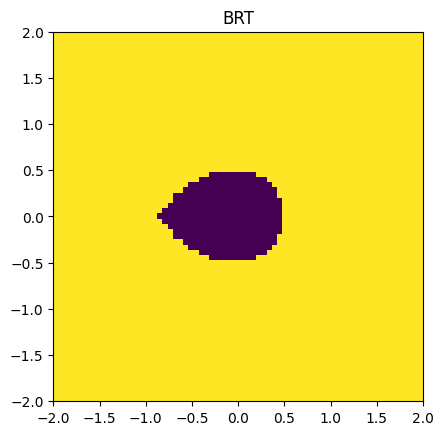

Computation Time: 39.80485463142395


In [ ]:
import time as timer
# Define the dynamical system
dyn_sys = Dubins3D()

# Define the computation grid
grid_min = np.array([-2., -2., 0.]) # in meters
grid_max = np.array([2., 2., 2 * np.pi]) # in meters

'''Q4.1 TODO: change resolution'''
N = 71
''' END TODO'''
num_cells = (N, N, N) # in cells
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(grid_min, grid_max),
                                                               num_cells,
                                                               periodic_dims=2)

failure_lx = jnp.linalg.norm(np.array([0.0, 0.0]) - grid.states[..., :2], axis=-1) - .5

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
# Time
time = 0.
target_time = -2.8

# Run the solver

t = timer.time()
target_values = hj.step(solver_settings, dyn_sys, grid, time, failure_lx, target_time)
plt.title("BRT")
plt.imshow(target_values[:, :, 0].T>0, origin='lower', extent=[-2, 2, -2, 2])
plt.show()
print("Computation Time:", timer.time() - t)


**4.1 TODO: Your markdown solution here**

In [ ]:
# @title 4D Dubins car

class Dubins4D(dynamics.ControlAndDisturbanceAffineDynamics):
    def __init__(self,
                 max_turn_rate=1.,
                 min_accel=-1.,
                 max_accel=1.,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None):

        if control_space is None:
            control_space = sets.Box(jnp.array([-max_turn_rate, min_accel]), jnp.array([max_turn_rate, max_accel]))
        if disturbance_space is None:
            disturbance_space = sets.Box(jnp.array([0, 0]), jnp.array([0, 0]))
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        _, _, psi, v = state
        return jnp.array([v * jnp.cos(psi), v * jnp.sin(psi), 0., 0.])

    def control_jacobian(self, state, time):
        x, y, _, _ = state
        return jnp.array([
            [0, 0],
            [0, 0],
            [1, 0],
            [0, 1]
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [1., 0.],
            [0., 1.],
            [0., 0.],
            [0., 0.]
        ])


Now, we provide a new dynamical system for a 4d Dubin's car with the following dynamics

$[\dot{p_x}, \dot{p_y},\dot{\theta}, \dot{v}] = [v \cos(\theta), v \cos(\theta), u_1, u_2]$

$u_1 \in [\omega_{min}, \omega_{max}]$

$u_2 \in [a_{min}, a_{max}]$

This more accurately models the robotic systems we may encounter in real life by adding a state dimension for linear velocity, and control input for the system's acceleration. However, we will see that the addition state dimensions greatly increase the computational burden of grid-based methods.


For the same N as above, plot the BRT and report the time taken to compute the BRT (this may take a while, N = 51 took us about 30 minutes).




100%|##########|  2.8000/2.799999952316284 [02:02<00:00, 43.70s/sim_s]


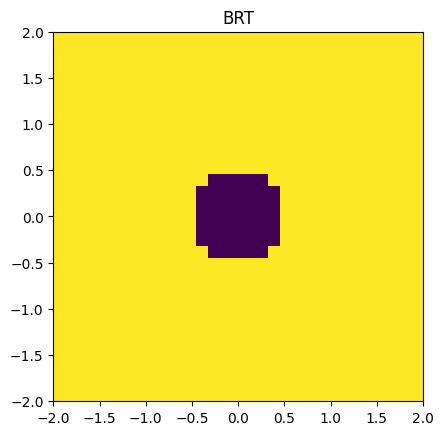

Computation Time: 128.3338007926941


In [ ]:

# Define the dynamical system
dyn_sys = Dubins4D()

# Define the computation grid
grid_min = np.array([-2., -2., 0., 0.]) # in meters
grid_max = np.array([2., 2., 2 * np.pi, 5.]) # in meters

'''Q4.2 TODO: change resolution'''
N = 31
''' END TODO '''
num_cells = (N, N, N, 15) # (nx, ny, ntheta, nv)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(grid_min, grid_max),
                                                               num_cells,
                                                               periodic_dims=2)
failure_lx = jnp.linalg.norm(np.array([0.0, 0.0]) - grid.states[..., :2], axis=-1) - .5

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
# Time
time = 0.
target_time = -2.8

# Run the solver

t = timer.time()
target_values_4d = hj.step(solver_settings, dyn_sys, grid, time, failure_lx, target_time)
plt.title("BRT")
plt.imshow(target_values_4d[:, :, 0, 0].T>0, origin='lower', extent=[-2, 2, -2, 2])
plt.show()
print("Computation Time:", timer.time() - t)

**4.2 TODO: Your markdown solution here**

DELIVERABLES:

Problem 1:
- 1.1.1 Conceptual Question 1
- 1.1.2 Conceptual Question 2
- 1.1.3 Conceptual Question 3
- 1.2 Implement $\ell(x)$
- 1.3 Visualize 2 different level sets for different object positions
- 1.4 Conceptual Question 4

Problem 2:
- 2.1 Run nominal planner and plot trajectory + controls
- 2.2 Implement safety filter, run planner, and plot trajectory + controls

Problem 3:
- 3.1 Conceptual question 5

Problem 4:
- 4.1 3 plots and times, 3D dubins car
- 4.2 3 plots and times, 4D dubins car